In [1]:
import torch
import torch.nn.functional as F
from datasets import *
from torchvision import transforms
from torch.utils.data import DataLoader
from models.ddpm_scheduler import NoiseScheduler
from models.ddpm import *
from models.embedding import * 
from models.mlp import *
from models.unet import UNetAttention
from datasets import PointDataset
from glob import glob
import os
import shutil
from einops import rearrange

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNetAttention(
    T=1000,
    image_size=64,
    in_channels=3,
    model_channels=128,
    out_channels=3,
    num_res_blocks=2,
    attention_resolutions=[8,4,2],
    dropout=0.15,
    channel_mult=(1,2,3,4),
    num_classes=3,
    num_atrs=2,
    num_heads=4,
    use_spatial_transformer=True,
    context_dim=128
).to(device)

x = torch.randn(1, 3, 64, 64, device=device)
c1 = torch.LongTensor([1]).to(device)
c2 = torch.LongTensor([0]).to(device)
timesteps = torch.randint(1000, (1,), device=device)

model(x, timesteps, c1, c2)

tensor([[[[-0.1193, -0.0518, -0.2444,  ..., -0.3043,  0.0558,  0.1699],
          [-0.2510, -0.5678,  0.1993,  ..., -0.4104, -0.6551, -0.3604],
          [-0.4412, -0.9354, -0.8705,  ..., -0.1971, -0.2636, -0.3387],
          ...,
          [-0.2702, -0.6208,  0.0168,  ..., -0.6132, -0.2321, -0.5650],
          [-0.1374, -0.2468, -0.4582,  ..., -0.5441, -0.5282, -0.3273],
          [-0.3922, -0.4511, -0.0691,  ..., -0.6284, -0.2646, -0.0045]],

         [[ 0.0743, -0.2154,  0.1704,  ..., -0.2170, -0.2065, -0.2867],
          [-0.2000, -0.3534,  0.0335,  ..., -0.3545,  0.0738, -0.1016],
          [-0.0265,  0.0737, -0.2399,  ..., -0.3321, -0.4142, -0.0762],
          ...,
          [-0.1669, -0.4091, -0.0671,  ...,  0.1019,  0.2194, -0.3285],
          [-0.1096, -0.1881, -0.2871,  ..., -0.5154, -0.1421, -0.0777],
          [-0.2175, -0.2747, -0.1997,  ..., -0.2341, -0.0204, -0.0968]],

         [[-0.0571,  0.2650,  0.1295,  ...,  0.0574,  0.2174,  0.0636],
          [ 0.3136,  0.0986, -

In [3]:
from models.engine import ConditionalGaussianDiffusionTrainer
trainer = ConditionalGaussianDiffusionTrainer(model, (0.0001, 0.02), 1000).to(device)
trainer(x, c1, c2)

tensor(14434.0430, device='cuda:0', grad_fn=<SumBackward0>)

In [5]:
h = 4
x = torch.randn(64, 128, 32, 32)
x = rearrange(x, 'b c h w -> b (h w) c')
print(f'x: {x.size()}')
c1 = torch.randn(64, 128)
c2 = torch.randn(64, 128)
c1, c2 = c1[:, None, :], c2[:, None, :]
context = torch.cat([c1, c2], dim=1)
to_q = nn.Linear(128, 512)
to_k = nn.Linear(128, 512)
to_v = nn.Linear(128, 512)
to_out = nn.Linear(512, 128)
q = to_q(x)
k = to_k(context)
v = to_v(context)

q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> (b h) n d', h=h), (q, k, v))
print(f'q: {q.size()}, k: {k.size()}, v:{v.size()}')

sim = torch.einsum('b i d, b j d -> b i j', q, k)

# attention, what we cannot get enough of
attn = sim.softmax(dim=-1)

out = torch.einsum('b i j, b j d -> b i d', attn, v)
out = rearrange(out, '(b h) n d -> b n (h d)', h=h)
out = to_out(out)

print(f'output dimension {out.size()}')

x: torch.Size([64, 1024, 128])
q: torch.Size([256, 1024, 128]), k: torch.Size([256, 2, 128]), v:torch.Size([256, 2, 128])
output dimension torch.Size([64, 1024, 128])


In [2]:
from models.unet import UNet
from models.engine import ConditionalGaussianDiffusionTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.randn(1, 3, 64, 64).to(device)
c1 = torch.LongTensor([0]).to(device)
c2 = torch.LongTensor([0]).to(device)
model = UNet(
        T = 1000,
        num_labels = 4,
        num_atr = 2,
        ch = 128,
        ch_mult=[1, 2, 2, 2],
        num_res_blocks = 2,
        dropout=0.15,
).to(device)

trainer = ConditionalGaussianDiffusionTrainer(model, (0.0001, 0.02), 1000).to(device)

loss = trainer(x, c1, c2)

In [3]:
loss

tensor(13872.8438, device='cuda:0', grad_fn=<SumBackward0>)

# Analyze UT Zappos50K

In [ ]:
root = '/root/notebooks/nfs/work/dataset/ut-zap50k-images'
mc = os.listdir(root)
for d in mc:
    for atr in glob(os.path.join(root, mc[3], '**')):
        print(atr.split('/')[-1])
        print(len(glob(os.path.join(atr, '**', '*.jpg'))))

In [39]:


target_dir = '/root/notebooks/nfs/work/dataset/conditional_ut/Slippers Flats/'
images = glob(os.path.join(target_dir, '**', '*.jpg'))
for image in images:
    shutil.move(image, os.path.join(target_dir, image.split('/')[-1]))
#     shutil.rmtree(os.path.join(target_dir, image.split('/')[-2]))

In [5]:
root = '/root/notebooks/nfs/work/dataset/conditional_ut'
n = 1000
target_dir = ['Boots Heels', 'Boots Flats']
for d in target_dir:
    images = glob(os.path.join(root, d, '*.jpg'))
    if len(images) < n:
        continue
    selected = random.sample(images, n)
    for image in images:
        if image not in selected:
            os.remove(image)

'ab'

In [17]:
target_dir = ['Shoes', 'Slippers', 'Sandals']
root = 'data/ut-zap50k-images'
save_dir = 'data/conditional_ut'
for d in target_dir:
    images = glob(os.path.join(root, d, "**", "**", "*.jpg"))
    for image in images:
        category = image.split('/')[2]
        name = image.split('/')[-1]
        
        if "Flat" in image:
            s = os.path.join(save_dir, f'Flat {category[:-1]}', name)
            shutil.copyfile(image, s)
        elif "Heel" in image:
            s = os.path.join(save_dir, f'Heel {category[:-1]}', name)
            shutil.copyfile(image, s)
        

# Test Diffusion trainer and Sampler

In [2]:
from models.unet import UNet
from models.engine import ConditionalGaussianDiffusionTrainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

image = torch.randn(32, 3, 128, 128).to(device)
c1 = torch.arange(0, 4)
c2 = torch.arange(0, 2)
c1 = c1.repeat(8, 1).permute(1, 0).reshape(-1)
c2 = c2.repeat(16)

c1, c2 = c1.to(device), c2.to(device)
print(c1.size(), c2.size())
model = UNet(
    T = 1000,
    num_labels = 4,
    num_atr = 2,
    ch = 128,
    ch_mult = [1, 2, 2, 2],
    num_res_blocks = 2,
    dropout = 0.15
).to(device)
model(image, torch.randint(1000, (1,), device=device), c1, c2)
trainer = ConditionalGaussianDiffusionTrainer(model, (0.0001, 0.02), 1000).to(device)
loss = trainer(image, c1, c2).sum()

loss.backward()

torch.Size([32]) torch.Size([32])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 128, 128])
torch.Size([32, 128, 128, 128])
torch.Size([32, 128, 128, 128])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 16, 16])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 32, 32])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 64, 64])
torch.Size([32, 256, 128, 128])
torch.Size([32, 128, 128, 128])
torch.Size([32, 128, 128, 128])


In [48]:
from models.engine import DDIMSampler
sampler = DDIMSampler(model, (0.0001, 0.02), 1000, 1.8).to(device)
z_t = torch.randn(8, 3, 32, 32, device=device)
x = sampler(z_t, label=c1, atr=c2, steps=100)
x = x.permute((0, 2, 3, 1))
print(x.size())

(0.0001, 0.02)


100%|██████████| 100/100 [00:03<00:00, 28.66it/s, step=1, sample=1]

torch.Size([8, 32, 32, 3])


In [24]:
x = x.cpu().numpy()
print(x.shape)

(8, 32, 32, 3)


In [29]:
import wandb
wandb.init(project='test image')
wandb.log({"examples": [wandb.Image(x[i, :, :, :]) for i in range(x.shape[0])]})

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


In [42]:
from torchvision.utils import save_image
n_sample = 8
c1 = torch.arange(0, 4)
c2 = torch.arange(0, 2)
c1 = c1.repeat(n_sample // 4, 1).permute(1, 0).reshape(-1)
c2 = c2.repeat(n_sample // 2)

images = torch.randn(8, 3, 128, 128)

save_image(images, 'test.png')

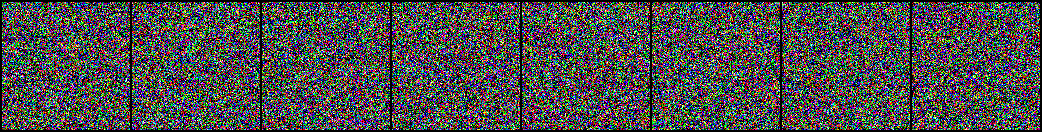

In [10]:
import matplotlib.pyplot as plt
import numpy as np

l_time_steps = np.asarray(list(range(0, 1000, 10)))
q_time_steps = (np.linspace(0, np.sqrt(1000 * 0.8), 100) ** 2).astype(np.int32)
print(l_time_steps)
print(q_time_steps)


[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350
 360 370 380 390 400 410 420 430 440 450 460 470 480 490 500 510 520 530
 540 550 560 570 580 590 600 610 620 630 640 650 660 670 680 690 700 710
 720 730 740 750 760 770 780 790 800 810 820 830 840 850 860 870 880 890
 900 910 920 930 940 950 960 970 980 990]
[  0   0   0   0   1   2   2   3   5   6   8   9  11  13  15  18  20  23
  26  29  32  35  39  43  47  51  55  59  63  68  73  78  83  88  94  99
 105 111 117 124 130 137 143 150 158 165 172 180 188 195 204 212 220 229
 238 246 255 265 274 284 293 303 313 323 334 344 355 366 377 388 399 411
 423 434 446 459 471 483 496 509 522 535 548 562 575 589 603 617 632 646
 661 675 690 705 721 736 752 768 783 800]


In [ ]:
a = torch.zeros(8, 128)
b = torch.ones(8, 128, 32, 32)
b += a[:, :, None, None]

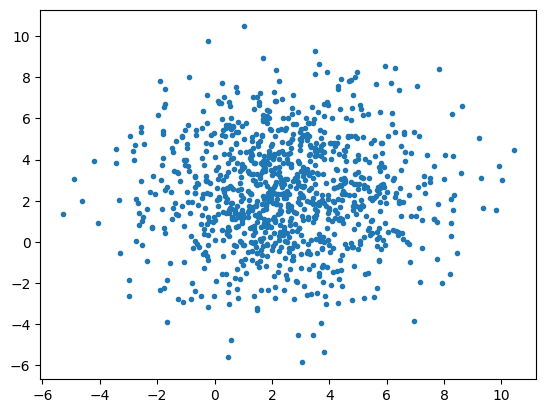

wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)
wandb: ERROR Dropped streaming file chunk (see wand

In [67]:
noise = torch.randn(1000, 2)
noise = noise * 2.5 + 2.5
x, y = noise[:, 0], noise[:, 1]
plt.plot(x, y, marker='.', linestyle="")

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

atr_embedding = LabelEmbedding(num_classes=5, hidden_size=10, dropout_prob=0.1).to(device)
obj_embedding = LabelEmbedding(num_classes=5, hidden_size=10, dropout_prob=0.1).to(device)
time_embedding = SinusoidalEmbedding(size=10)
nn_model = MLP(
    hidden_layers=3,
    input_size=2,
    emb_size=10,
    hidden_size=32,
).to(device)

ns = NoiseScheduler(50)

params = list(atr_embedding.parameters()) + list(obj_embedding.parameters()) + list(nn_model.parameters())
optimizer = torch.optim.AdamW(params, lr=0.1)

x = torch.FloatTensor([[0.9, 0.9]]).to(device)
c = torch.LongTensor([[0,1]]).to(device)
noise = torch.randn(x.size())
timesteps = torch.randint(0, 50, (1,))

c1, c2 = c[:, 0], c[:, 1]
c1 = obj_embedding(c1)
c2 = atr_embedding(c2)
t = time_embedding(timesteps)
x_t = ns.add_noise(x.cpu(), noise, timesteps)

x_t = x_t.to(device)
t = t.to(device)
noise = noise.to(device)
noise_pred = nn_model(x_t, c1, c2, t)
loss = F.mse_loss(noise_pred, noise)
loss.backward()

tensor(0.9265, device='cuda:0', grad_fn=<MseLossBackward0>)

In [31]:
from tqdm.auto import tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
n_samples=25
x_i = torch.randn(n_samples, 2).to(device)

# timesteps list
timesteps = list(range(50))[::-1]

# create conditions of each class
c1 = torch.arange(0, 5)
c2 = torch.arange(0, 5)
c1 = c1.repeat(5)
c2 = c2.repeat(5)

c1, c2 = c1.to(device), c2.to(device)

# conditional embedding
c1 = obj_embedding(c1)
c2 = atr_embedding(c2)

# unconditional embedding, create zero embedding vector
c1_unc = torch.zeros(c1.size(), device=device)
c2_unc = torch.zeros(c2.size(), device=device)

for i, t in enumerate(tqdm(timesteps)):
    t = torch.from_numpy(np.repeat(t, n_samples))
    t_emb = time_embedding(t).to(device)
#     t_emb = t_emb.to(device)
    with torch.no_grad():
        cond_pred = nn_model(x_i, c1, c2, t_emb)
        uncond_pred = nn_model(x_i, c1_unc, c2_unc, t_emb)

        # classifier-free guidance
        eps = (1 + 0.1) * cond_pred - 0.1 * uncond_pred

        x_i = ns.step(eps.cpu(), t[0], x_i.cpu()).to(device)
x_i.size()


100%|██████████| 50/50 [00:00<00:00, 985.94it/s]


torch.Size([25, 2])

In [18]:
timesteps = list(range(50))[::-1]
t = timesteps[0]
t = torch.from_numpy(np.repeat(t, 25))

array([49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49,
       49, 49, 49, 49, 49, 49, 49, 49])

In [20]:
torch.from_numpy?

Docstring:
from_numpy(ndarray) -> Tensor

Creates a :class:`Tensor` from a :class:`numpy.ndarray`.

The returned tensor and :attr:`ndarray` share the same memory. Modifications to
the tensor will be reflected in the :attr:`ndarray` and vice versa. The returned
tensor is not resizable.

It currently accepts :attr:`ndarray` with dtypes of ``numpy.float64``,
``numpy.float32``, ``numpy.float16``, ``numpy.complex64``, ``numpy.complex128``,
``numpy.int64``, ``numpy.int32``, ``numpy.int16``, ``numpy.int8``, ``numpy.uint8``,
and ``numpy.bool``.

.. warning::
    Writing to a tensor created from a read-only NumPy array is not supported and will result in undefined behavior.

Example::

    >>> a = numpy.array([1, 2, 3])
    >>> t = torch.from_numpy(a)
    >>> t
    tensor([ 1,  2,  3])
    >>> t[0] = -1
    >>> a
    array([-1,  2,  3])
Type:      builtin_function_or_method

In [6]:
x = torch.randn(1, 2).to(device)
c1 = torch.Tensor([1]).to(device).type(torch.LongTensor).to(device)
c2 = torch.Tensor([1]).to(device).type(torch.LongTensor).to(device)
c = torch.stack((c1, c2), axis=1)
loss = ddpm(x, c)
loss.item()

torch.Size([1, 2]) torch.Size([1, 10]) torch.Size([1, 10]) torch.Size([1, 10])


0.03332122415304184

In [20]:
ea = a_emb(c1)
eo = o_emb(c2)
_t = torch.randint(1, 51, (1,)).to(device)
t = t_emb(_t / 50)
torch.cat((x, ea, eo, t), axis=-1)

tensor([[-0.6172, -1.2266,  0.3529, -0.3628, -0.5103, -1.1034,     nan,     nan]],
       device='cuda:0', grad_fn=<CatBackward0>)

In [10]:
x = torch.randn(25, 2)
c1 = torch.arange(0, 5).view(-1, 1)
c2 = torch.arange(0, 5)
c2 = c2.repeat(5)
c1 = c1.repeat(1, 5)
c1 = c1.view(-1)
c = torch.stack((c1, c2), axis=1)
c.size()

torch.Size([25, 2])

c1 = torch.arange(0, 5)
c2 = torch.arange(0, 5)
c1 = c1.repeat(5, 1).permute(1, 0).reshape(-1)
print(c1, c1.size())

# Test wandb library

In [66]:
import wandb
import random

wandb.init(
    project="random test",
)

print(wandb.config)

# # simulate training
# epochs = 10
# offset = random.random() / 5
# for epoch in range(1, epochs + 1):
#     acc = 1 - 2 ** -epoch - random.random() / epoch - offset
#     loss = 2 ** -epoch + random.random() / epoch + offset
    
#     # log metrics to wandb
#     wandb.log({"acc": acc, "loss": loss})
    
# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

{}


# Generate point dataset

In [42]:
import os
save_root = 'data/2DPoints'
dirs = os.listdir(save_root)
radius = 0.1
num_samples = 1000
a = []

for i in range(1, 6):
    tmp = [i - 0.1] * 5
    a.extend(tmp)
b = list(map(lambda x: x - 0.1, range(1, 6))) * 5
centers = list(zip(a,b))

for center, d in zip(centers, dirs):
    p = generate_circle(center, radius, num_samples)
    d = f'A{int(center[0]+0.1)} B{int(center[1]+0.1)}'
    np.save(os.path.join(save_root, d, 'points.npy'), p)

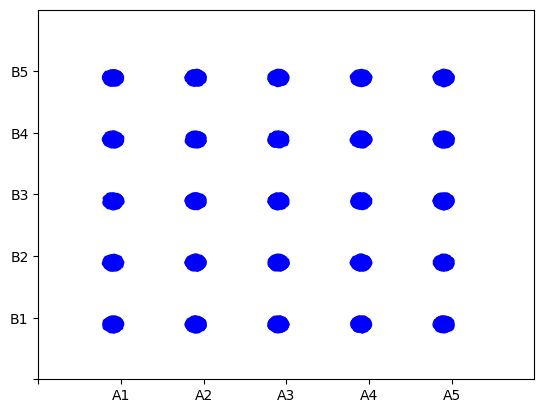

In [43]:
from glob import glob
npys = glob(os.path.join(save_root, '**', '*npy'))
p = np.load('data/2DPoints/A1 B1/points.npy')
plt.xticks(np.arange(0,6), ['', 'A1', 'A2', 'A3', 'A4', 'A5'])
plt.yticks(np.arange(0,6), ['', 'B1', 'B2', 'B3', 'B4', 'B5'])
plt.xlim([0, 6])
plt.ylim([0, 6])

for npy in npys:
    p = np.load(npy)
    plt.plot(p[:, 0], p[:, 1], marker='.', color='blue', linestyle="")